## Compressive Sensing with factorized operator

This notebooks consider a compressive sensing problem:

$$
\arg min_\mathbf{x}  = \frac{1}{2} \|\mathbf{Ax}-\mathbf{y}\|_2^2 + \lambda \|\mathbf{x}\|_1  
$$

where the matrix $\mathbf{A}$ is a randomized sampling matrix. 

We investigate here the scenario where the matrix $\mathbf{A}$ is dense and can be explicitely factorized via Cholesky factorization and used in subsequent operations when computing the proximal of the L2 operator. We will see that this drammatically reduce the cost of the L2 operator, and the overall solution of the problem at hand.

In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import pylops
import pyproximal

np.random.seed(0)

In [2]:
n, m = 40, 100
mava = 10

# model
x = np.zeros(m)
iava = np.random.permutation(np.arange(m))[:mava]
x[iava] = np.random.normal(0, 1, mava)

# operator
A = np.random.normal(0, 1, (n, m))
Aop = pylops.MatrixMult(A)
y = Aop * x

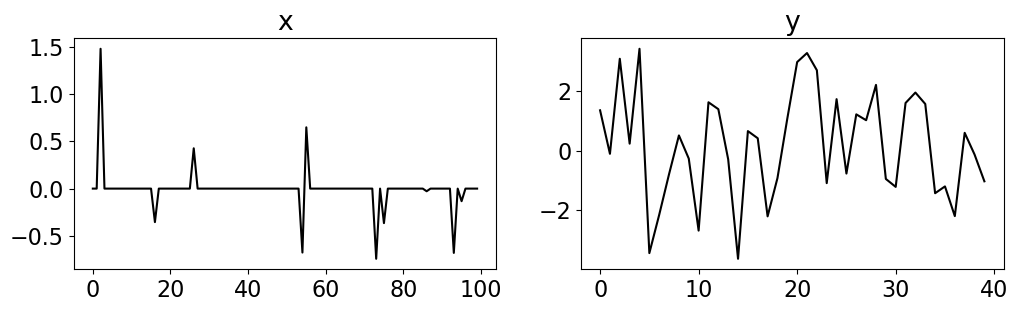

In [3]:
fig, axs = plt.subplots(1, 2, figsize=(12, 3))
axs[0].plot(x, 'k')
axs[0].set_title('x')
axs[1].plot(y, 'k')
axs[1].set_title('y');

ADMM
---------------------------------------------------------
Proximal operator (f): <class 'pyproximal.proximal.L2.L2'>
Proximal operator (g): <class 'pyproximal.proximal.L1.L1'>
tau = 3.801281e-03	niter = 1000

   Itn       x[0]          f           g       J = f + g
     1   1.41877e-02   3.499e+01   2.308e+00   3.730e+01
     2   1.64682e-02   2.262e+01   3.391e+00   2.601e+01
     3   1.91209e-02   1.484e+01   4.359e+00   1.920e+01
     4   1.94689e-02   1.037e+01   5.042e+00   1.541e+01
     5   1.83581e-02   7.599e+00   5.544e+00   1.314e+01
     6   1.62899e-02   5.788e+00   5.924e+00   1.171e+01
     7   1.34454e-02   4.564e+00   6.203e+00   1.077e+01
     8   9.97758e-03   3.700e+00   6.406e+00   1.011e+01
     9   6.18277e-03   3.069e+00   6.574e+00   9.642e+00
    10   2.25635e-03   2.594e+00   6.694e+00   9.288e+00
   101  -8.28588e-06   4.620e-01   5.794e+00   6.256e+00
   201   4.75455e-06   4.052e-01   5.258e+00   5.663e+00
   301   1.05431e-05   2.859e-01   5.149e+00 

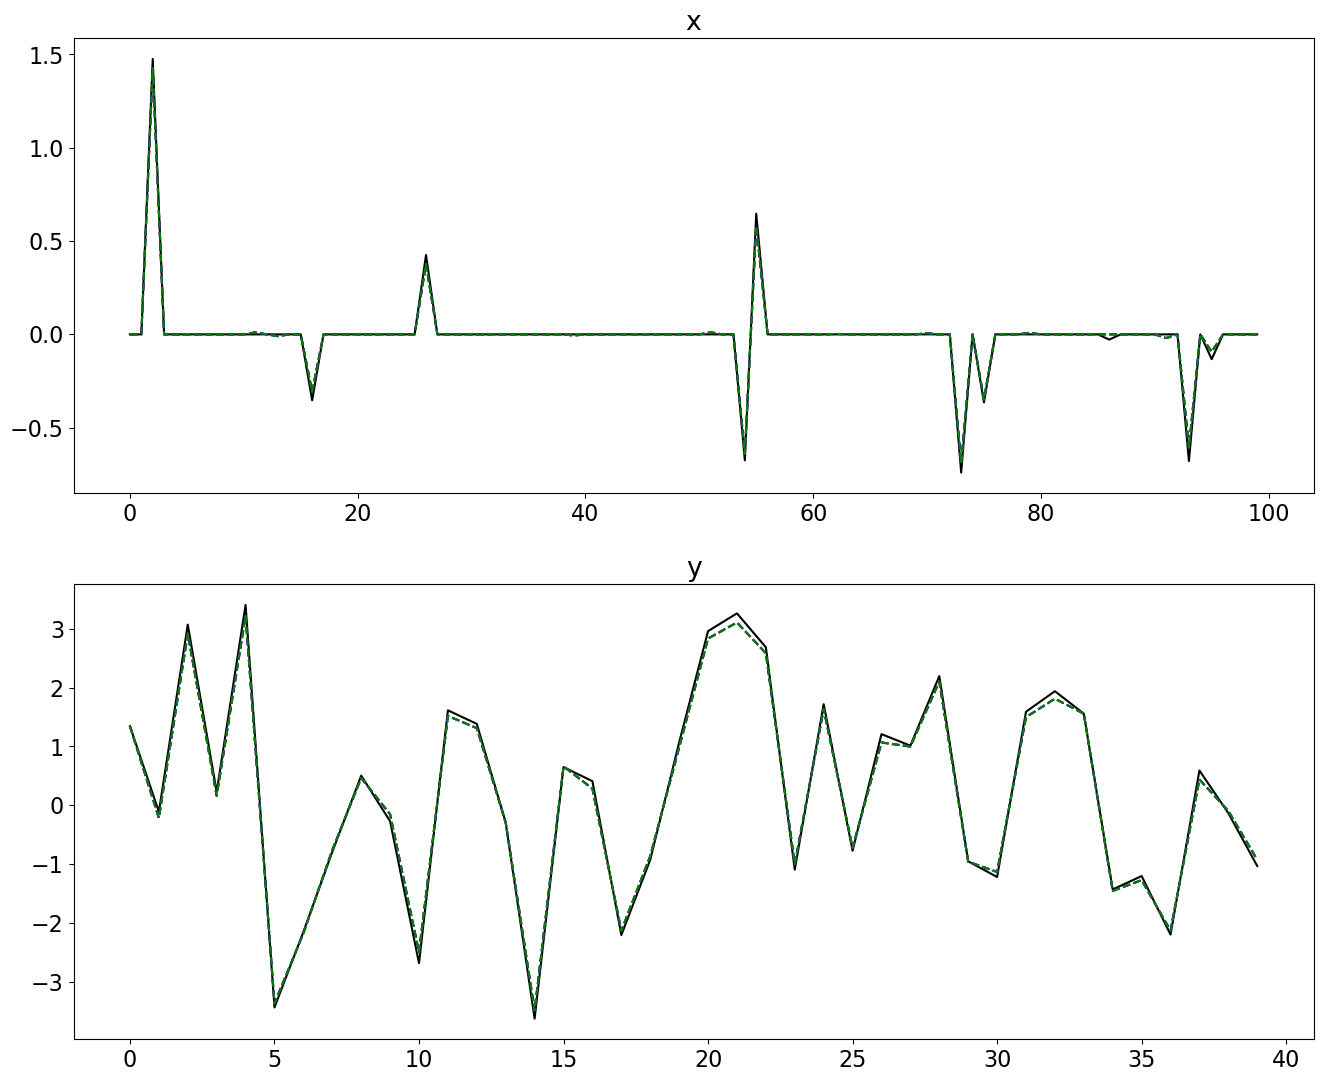

In [4]:
f = pyproximal.L2(Aop, y, niter=20)
f1 = pyproximal.L2(Aop, y, densesolver='scipy')
f2 = pyproximal.L2(Aop, y, densesolver='factorize')
g = pyproximal.L1()

ATA = Aop.H * Aop
ATA.explicit = False
L = np.abs(ATA.eigs(1)[0])
niter = 1000
tau= 0.95/L

xinv = pyproximal.optimization.primal.ADMM(f, g, np.zeros_like(x),
                                           tau,  niter=niter, show=True)[0]

xinv1 = pyproximal.optimization.primal.ADMM(f1, g, np.zeros_like(x),
                                            tau, niter=niter, show=True)[0]

xinv2 = pyproximal.optimization.primal.ADMM(f2, g, np.zeros_like(x),
                                            tau, niter=niter, show=True)[0]


fig, axs = plt.subplots(2, 1, figsize=(16, 13))
axs[0].plot(x, 'k')
axs[0].plot(xinv, '--r')
axs[0].plot(xinv1, '--b')
axs[0].plot(xinv2, '--g')
axs[0].set_title('x')
axs[1].plot(y, 'k')
axs[1].plot(Aop @ xinv, '--r')
axs[1].plot(Aop @ xinv1, '--b')
axs[1].plot(Aop @ xinv2, '--g')
axs[1].set_title('y');

In [5]:
%timeit -n 5 -r 3 pyproximal.optimization.primal.ADMM(f, g, np.zeros_like(x), tau, niter=niter)
%timeit -n 5 -r 3 pyproximal.optimization.primal.ADMM(f1, g, np.zeros_like(x), tau, niter=niter)
%timeit -n 5 -r 3 pyproximal.optimization.primal.ADMM(f2, g, np.zeros_like(x), tau, niter=niter)

103 ms ± 594 μs per loop (mean ± std. dev. of 3 runs, 5 loops each)
103 ms ± 4.29 ms per loop (mean ± std. dev. of 3 runs, 5 loops each)
17.2 ms ± 910 μs per loop (mean ± std. dev. of 3 runs, 5 loops each)


In [6]:
np.linalg.norm(x-xinv), np.linalg.norm(x-xinv1), np.linalg.norm(x-xinv2)

(np.float64(0.15373153132284514),
 np.float64(0.15373153132284514),
 np.float64(0.15373153132285236))